In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

import treecorr
import pyccl

from hydra import initialize, compose
from hydra.utils import instantiate

import pytorch_lightning as pl
from pytorch_lightning.utilities import move_data_to_device

from bliss.global_env import GlobalEnv

device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

---

### Generate posterior samples of shear and convergence

In [2]:
ckpt = "/data/scratch/twhit/checkpoints/trained_encoder_train50test40.ckpt"

with initialize(config_path="../../../", version_base=None):
    cfg = compose("lensing_config_dc2", {
        "train.pretrained_weights=" + ckpt,
        })

seed = pl.seed_everything(cfg.train.seed)
GlobalEnv.seed_in_this_program = seed
GlobalEnv.current_encoder_epoch = 0

Seed set to 123123


In [3]:
data_source = instantiate(cfg.train.data_source)
data_source.setup("test")
test_dl = data_source.test_dataloader()

In [4]:
encoder = instantiate(cfg.encoder).to(device)
encoder_state_dict = torch.load(cfg.train.pretrained_weights, map_location=device)["state_dict"]
encoder.load_state_dict(encoder_state_dict)
encoder = encoder.eval()

In [5]:
num_samples = 2000

shear1_true = torch.zeros(len(test_dl), 8, 8, device=device)
shear1_samples = torch.zeros(len(test_dl), num_samples, 8, 8, device=device)
shear1_mode = torch.zeros(len(test_dl), 8, 8, device=device)
shear2_true = torch.zeros(len(test_dl), 8, 8, device=device)
shear2_samples = torch.zeros(len(test_dl), num_samples, 8, 8, device=device)
shear2_mode = torch.zeros(len(test_dl), 8, 8, device=device)
convergence_true = torch.zeros(len(test_dl), 8, 8, device=device)
convergence_samples = torch.zeros(len(test_dl), num_samples, 8, 8, device=device)
convergence_mode = torch.zeros(len(test_dl), 8, 8, device=device)
ra = torch.zeros(len(test_dl), 8, 8, device=device)
dec = torch.zeros(len(test_dl), 8, 8, device=device)
redshift = torch.zeros(len(test_dl), 8, 8, device=device)

i = -1
for b in test_dl:
    i += 1
    batch = move_data_to_device(b, device)
    
    shear1_true[i] = batch['tile_catalog']['shear_1'].squeeze()
    shear2_true[i] = batch['tile_catalog']['shear_2'].squeeze()
    convergence_true[i] = batch['tile_catalog']['convergence'].squeeze()
    ra[i] = batch['tile_catalog']['ra'].squeeze()
    dec[i] = batch['tile_catalog']['dec'].squeeze()
    redshift[i] = batch['tile_catalog']['redshift'].squeeze()
    
    with torch.no_grad():
        input_lst = [inorm.get_input_tensor(batch) for inorm in encoder.image_normalizers]
        inputs = torch.cat(input_lst, dim=2)
        x_features = encoder.features_net(inputs)
        x_cat_marginal = encoder.catalog_net(x_features)
        
        for n in range(num_samples):            
            sample = encoder.var_dist.sample(x_cat_marginal, use_mode=False, return_base_cat=True)
            mode = encoder.var_dist.sample(x_cat_marginal, use_mode=True, return_base_cat=True)
            shear1_samples[i,n] = sample['shear_1'].squeeze()
            shear1_mode[i] = mode['shear_1'].squeeze()
            shear2_samples[i,n] = sample['shear_2'].squeeze()
            shear2_mode[i] = mode['shear_2'].squeeze()
            convergence_samples[i,n] = sample['convergence'].squeeze()
            convergence_mode[i] = mode['convergence'].squeeze()

---

### Compute two-point correlation function (2PCF) for each sample

In [6]:
min_sep = 1
max_sep = 80
sep_units = "arcmin"

bin_type = 'Linear'
nbins = 10

xip = torch.zeros(num_samples, nbins, device = device)
xim = torch.zeros(num_samples, nbins, device = device)

In [7]:
for n in range(num_samples):
    if n % 100 == 0:
        print(n)
    treecorr_catalog = treecorr.Catalog(ra = ra.flatten().cpu(), ra_units = "deg",
                                        dec = dec.flatten().cpu(), dec_units = "deg",
                                        g1 = shear1_samples[:,n,...].flatten().cpu(),
                                        g2 = shear2_samples[:,n,...].flatten().cpu(),
                                        k = convergence_samples[:,n,...].flatten().cpu())
    
    gg = treecorr.GGCorrelation(min_sep = min_sep, max_sep = max_sep, sep_units = sep_units,
                                bin_type = bin_type, nbins = nbins)
    gg.process(treecorr_catalog)
    
    xip[n] = torch.from_numpy(gg.xip.copy()).to(device)
    xim[n] = torch.from_numpy(gg.xim.copy()).to(device)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


---

### 2PCFs for true DC2 shear and convergence

In [8]:
treecorr_catalog = treecorr.Catalog(ra = ra.flatten().cpu(), ra_units = "deg",
                                    dec = dec.flatten().cpu(), dec_units = "deg",
                                    g1 = shear1_true.flatten().cpu(),
                                    g2 = shear2_true.flatten().cpu(),
                                    k = convergence_true.flatten().cpu())
    
gg = treecorr.GGCorrelation(min_sep = min_sep, max_sep = max_sep, sep_units = sep_units,
                            bin_type = bin_type, nbins = nbins)
gg.process(treecorr_catalog)

r = np.exp(gg.meanlogr)

In [9]:
xip_true = torch.from_numpy(gg.xip.copy()).to(device)
xim_true = torch.from_numpy(gg.xim.copy()).to(device)

---

### Theoretical 2PCFs using `pyccl`

In [10]:
wmap7_cosmo = pyccl.cosmology.Cosmology(Omega_c = 0.22,
                                        Omega_b = 0.048,
                                        h = 0.71,
                                        n_s = 0.963,
                                        sigma8 = 0.8)

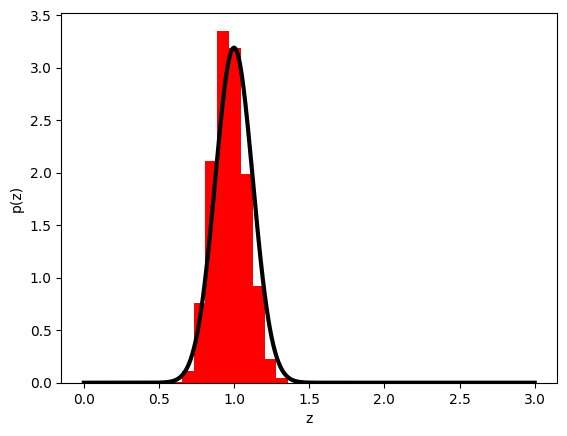

In [11]:
z = np.linspace(0.001, 3, 512)
n = norm.pdf(z, 1.0, 0.125)

_ = plt.hist(redshift.flatten().cpu(), bins = 10, density = True, color = 'red')
_ = plt.plot(z, n, color = 'black', linewidth = 3)
_ = plt.xlabel('z')
_ = plt.ylabel('p(z)')

In [12]:
lensing_tracer = pyccl.WeakLensingTracer(wmap7_cosmo, dndz=(z, n))

ell = np.arange(10, 2000)
cl = pyccl.angular_cl(wmap7_cosmo, lensing_tracer, lensing_tracer, ell)

In [13]:
theta_degrees = r/60  # 1 degree is 60 arcmins

xip_theory = pyccl.correlation(cosmo = wmap7_cosmo,
                               ell = ell, C_ell = cl,
                               theta = theta_degrees, type = 'GG+')
xim_theory = pyccl.correlation(cosmo = wmap7_cosmo,
                               ell = ell, C_ell = cl,
                               theta = theta_degrees, type = 'GG-')

---

### Comparison

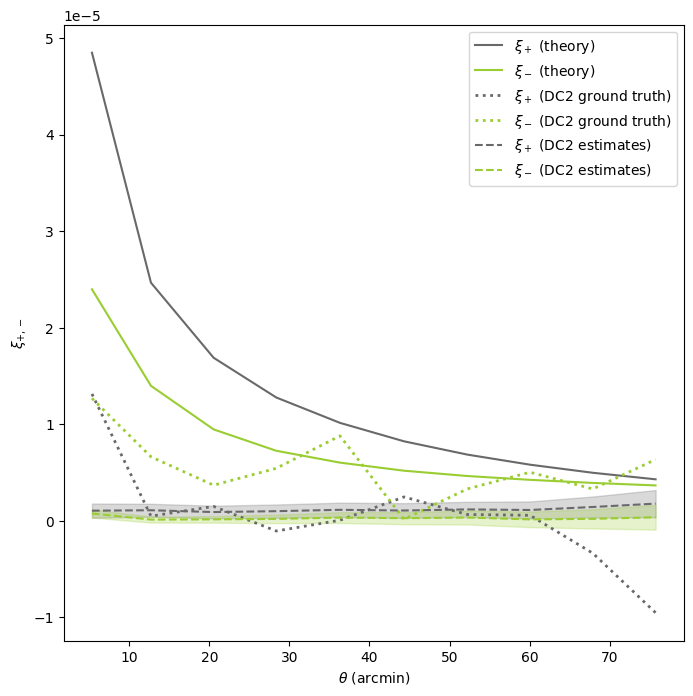

In [14]:
plus_color = 'dimgray'
minus_color = 'yellowgreen'

fig, ax = plt.subplots(1, 1, figsize = (8,8))

_ = ax.plot(r, xip_theory, color = plus_color, label = "$\\xi_+$ (theory)")
_ = ax.plot(r, xim_theory, color = minus_color, label = "$\\xi_-$ (theory)")
_ = ax.plot(r, xip_true.cpu(), color = plus_color, linestyle = 'dotted', linewidth = 2, label = '$\\xi_+$ (DC2 ground truth)')
_ = ax.plot(r, xim_true.cpu(), color = minus_color, linestyle = 'dotted', linewidth = 2, label = '$\\xi_-$ (DC2 ground truth)')
_ = ax.plot(r, xip.mean(0).cpu(), color = plus_color, linestyle = '--', label = '$\\xi_+$ (DC2 estimates)')
_ = ax.plot(r, xim.mean(0).cpu(), color = minus_color, linestyle = '--', label = '$\\xi_-$ (DC2 estimates)')
_ = ax.fill_between(r, xip.mean(0).cpu() - 1.96*xip.std(0).cpu(), xip.mean(0).cpu() + 1.96*xip.std(0).cpu(),
                    color = plus_color, alpha = 0.25)
_ = ax.fill_between(r, xim.mean(0).cpu() - 1.96*xim.std(0).cpu(), xim.mean(0).cpu() + 1.96*xim.std(0).cpu(),
                    color = minus_color, alpha = 0.25)
_ = ax.legend()

_ = ax.set_xlabel(r'$\theta$ (arcmin)')
_ = ax.set_ylabel(r'$\xi_{+,-}$')

fig.savefig("figures/twopointcorrelation.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

---